In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
# from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [2]:
model_size_dict = {
    'base': {
        'config': '03_15_18_01/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/03_15_18_01/checkpoints/checkpoint.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
# submodel = build_sam2(config, ck, 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
submodel, object_labels = build_sam2_predict(config, ck, device=device)
im_pred = SAM2ImagePredictor(submodel)
im_pred._bb_feat_sizes = [
        (128, 128),
        (64, 64),
        (32, 32),
    ]

OmegaConf resolved successfully


In [3]:
# Dataset
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.485/.229, -.456/.224, -.406/.225]
revert_std=[1/.229, 1/.224, 1/.225]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           len_video=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



100%|██████████| 3/3 [00:20<00:00,  6.73s/it]

Lenght of the dataset! 102


Index: 66
Segmentation Mask:
Object Mask:


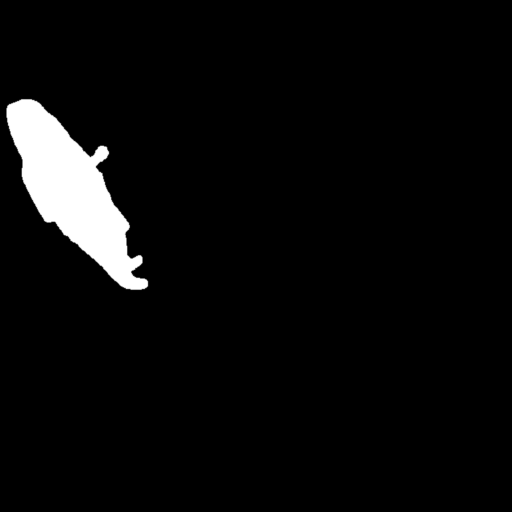

Input Image:


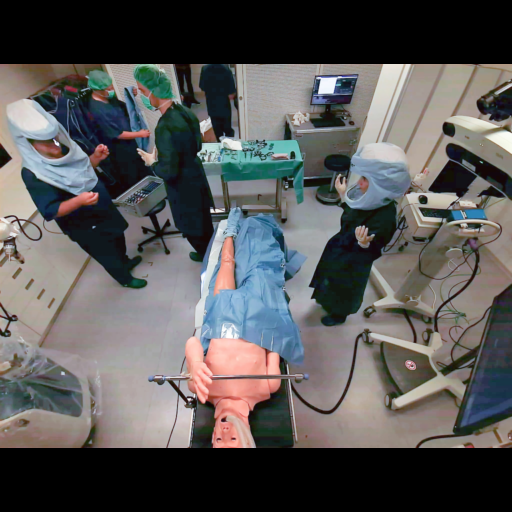

In [4]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False

while True:
    if if_break:
        break
    idx = np.random.randint(0, len(test_dataset))
    # idx = 25424
    print(f'Index: {idx}')
    frame_obj_list, frames_segmentation_mask = test_dataset[idx]
    for i in range(len_video):
        image = frame_obj_list.frames[i].data
        # Save the unnormalized image
        print('Segmentation Mask:')
        # frames_segmentation_mask[i].show()
        print('Object Mask:')
        for j in range(len_objects):
            exist = torch.any(frame_obj_list.frames[i].objects[j].segment == True)
            toPILimage(frame_obj_list.frames[i].objects[j].segment/255).show() if exist else None
            if_break = True if exist else if_break

print('Input Image:')
toPILimage(revert_transform(image)).show()
image = toPILimage(image)
im_pred.set_image(image)

In [5]:
# Point Copy-Paste from the sam2_tune
O = len_objects
points = torch.tensor([[i,i] for i in object_labels]).unsqueeze(1)
labels = torch.tensor([[1]]).tile((O,1))
print(f'Points: {points.data}')
print(f'Labels: {labels.item()}')

Points: tensor([[[10, 10]]])
Labels: 1


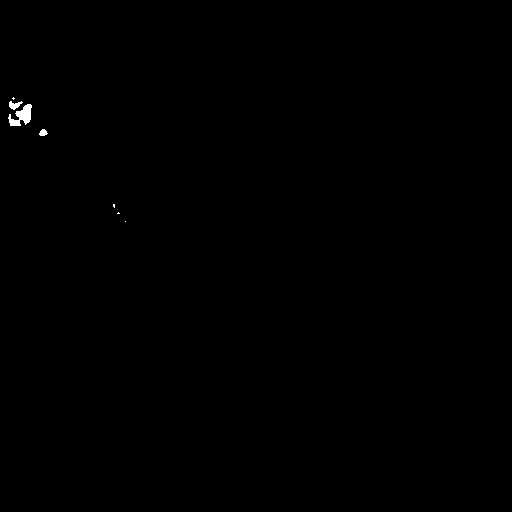

In [6]:

# Predict
multimask_output = True
masks, scores, logits = im_pred.predict(
point_coords=points,
point_labels=labels,
multimask_output=multimask_output,
)
best_masks = deepcopy(masks)
if multimask_output:
    masks = masks[None,:,:,:] if len(masks.shape) == 3 else masks
    scores = scores[None,:] if len(scores.shape) == 1 else scores
    sorted_ind = np.argsort(scores, axis=1)[:,-1]
    obj_ind = np.arange(len_objects)
    best_masks = masks[obj_ind,sorted_ind]
    best_scores = scores[obj_ind,sorted_ind]
    # best_logits = logits[obj_ind,sorted_ind]
for idx, mask in enumerate(best_masks):
    toPILimage((mask*255).astype(np.uint8)).show()